In [1]:
using PauliPropagation
using Base.Threads: @threads, Atomic, atomic_add!
using Plots
using Statistics
using Serialization
using OrderedCollections
using JSON
using Random
using ProfileView
gr()
include("PauliPropagation.jl/helpers.jl")

produceLabels2 (generic function with 1 method)

In [2]:
using PyCall

py"""
import sys
import os
from pathlib import Path

current_dir = Path.cwd()
project_root = current_dir

# Path to the venv (relative to project root)
venv_path = project_root / 'questenv'

if sys.platform == 'win32':
    site_packages = venv_path / 'Lib' / 'site-packages'
else:
    python_version = f'python{sys.version_info.major}.{sys.version_info.minor}'
    site_packages = venv_path / 'lib' / python_version / 'site-packages'

sys.path.insert(0, str(site_packages))
sys.prefix = str(venv_path)

sys.path.insert(0, str(project_root))

# Importing the module
import StateVecEvol
"""

mymod = py"StateVecEvol"

PyObject <module 'StateVecEvol' from 'c:\\Users\\asutc\\Documents\\Uni\\EPFL\\ML\\Project 2\\MLforPauliProp\\StateVecEvol.py'>

Here we compare different uses of our model. Standard PauliPropagation is also implemented to use as a baseline.

To do so we need to calculate the exact overlap with zero, which is done using a different propagation method; namely, exact state vector evolution, since it is faster than Pauli Propagation for exact solutions.


In [4]:
numQbits = 20
numLayers = 20
topology = bricklayertopology(numQbits; periodic=true) #specifies that this is a 1d ring
circuit = tfitrottercircuit(numQbits, numLayers; topology=topology) # puts the hamiltonian on the ring
dt = 0.1
parameters = ones(countparameters(circuit)) * dt

generators = [PauliString(numQbits, [:Z, :Z], [1, 2])] # this can be a list of generators to test on; the starting points of the ensuing propagationg

cp_grid = [1e-5,1e-15,1e-30]
scythe_grid = [1e-10,1e-18,1e-25]
scythe_grid2 = [8.5e-11,9e-19,1e-26] # change this to find values that match accuracies or timings
exactResults = zeros(length(generators))
PPmethodResults = zeros(length(generators), length(cp_grid))
PPtimings = zeros(length(generators), length(cp_grid))
PPaccuracies = zeros(length(generators), length(cp_grid))
demonResults = zeros(length(generators), length(scythe_grid))
demonTimings = zeros(length(generators), length(scythe_grid))
demonAccuracies = zeros(length(generators), length(scythe_grid))
demonResults2 = zeros(length(generators), length(scythe_grid))
demonTimings2 = zeros(length(generators), length(scythe_grid))
demonAccuracies2 = zeros(length(generators), length(scythe_grid))
demonResults3 = zeros(length(generators), length(scythe_grid))
demonTimings3 = zeros(length(generators), length(scythe_grid))
demonAccuracies3 = zeros(length(generators), length(scythe_grid))

for (obsidx,obs) in enumerate(generators)
    elapsed_time = @elapsed begin
        exactAns = mymod.get_SV_expVal(numQbits, numLayers, topology, obs.term)
    end
    println("Exact sol found in ",elapsed_time , "s.")
    exactResults[obsidx] =  exactAns

    checkpoint_path = "models/best_demon_len=100004_qbits=20_{Gen=true_L1=32_cp=0.00123418_w=Inf}_{L2=2_cp=1.0e-15}.pth"
    modelParams = Dict([("qbits",20), ("L2",2), ("hidden_dim",96),("expansion_ratio",8)])

    for (scytheidx,scythe) in enumerate(scythe_grid)
        psum = PauliSum(obs) # demon Labels expects a psum.
        elapsed_time = @elapsed begin
            topo = "ring"
            labels, infcetime = demonLabels(numLayers, psum, topology, dt, modelParams, checkpoint_path, scythe_grid[scytheidx], 0)
        end
        demonTimings[obsidx,scytheidx] = elapsed_time
        demonResults[obsidx,scytheidx] = labels
    end

    checkpoint_path = "models/best_demon_len=99699_qbits=20_{Gen=true_L1=34_cp=0.00123418_w=Inf}_{L2=2_cp=1.0e-15}.pth"
    modelParams = Dict([("qbits",20), ("L2",2), ("hidden_dim",96),("expansion_ratio",8)])

    for (scytheidx,scythe) in enumerate(scythe_grid)
        psum = PauliSum(obs) # demon Labels expects a psum.
        elapsed_time = @elapsed begin
            topo = "ring"
            labels, infcetime = demonLabels(numLayers, psum, topology, dt, modelParams, checkpoint_path, scythe_grid2[scytheidx], 0)
        end # L2 is hard coded here depending on the model. Ensure it matches the file name. 
        demonTimings3[obsidx,scytheidx] = elapsed_time
        demonResults3[obsidx,scytheidx] = labels
    end


    checkpoint_path = "models/best_demon_len=8299_qbits=20_{Gen=true_L1=32_cp=0.005_w=Inf}_{L2=3_cp=1.0e-19}.pth"
    modelParams = Dict([("qbits",20), ("L2",3), ("hidden_dim",48),("expansion_ratio",10)])

    for (scytheidx,scythe) in enumerate(scythe_grid)
        psum = PauliSum(obs) # demon Labels expects a psum.
        elapsed_time = @elapsed begin
            topo = "ring"
            labels, infcetime = demonLabels(numLayers, psum, topology, dt, modelParams, checkpoint_path, scythe_grid2[scytheidx], 0)
        end # L2 is hard coded here depending on the model. Ensure it matches the file name. 
        demonTimings2[obsidx,scytheidx] = elapsed_time
        demonResults2[obsidx,scytheidx] = labels
    end

    for (cpidx,cp) in enumerate(cp_grid)
        psum = PauliSum(numQbits)
        add!(psum,obs) # produceLabels expects a psum, but here we want to time each separately
        elapsed_time = @elapsed begin
            labels = produceLabels(numQbits, psum, numLayers, cp, topology, dt)
        end
        PPtimings[obsidx,cpidx] = elapsed_time
        PPmethodResults[obsidx,cpidx] = labels.vals[1][1]
    end
end



applied circuit was: ['Z', 'Z', 'I...']
Exact sol found in 1.1797862s.
Layer 1: feature=0.0300364s, kept 1 paulis out of 1
Layer 2: feature=0.0034506s, kept 13 paulis out of 13
Layer 3: feature=0.0035643s, kept 37 paulis out of 43
Layer 4: feature=0.0038515s, kept 47 paulis out of 77
Layer 5: feature=0.0029974s, kept 51 paulis out of 77
Layer 6: feature=0.0045776s, kept 62 paulis out of 93
Layer 7: feature=0.0063699s, kept 68 paulis out of 119
Layer 8: feature=0.0053157s, kept 72 paulis out of 119
Layer 9: feature=0.0064633s, kept 76 paulis out of 119
Layer 10: feature=0.0050503s, kept 78 paulis out of 119
Layer 11: feature=0.0048666s, kept 84 paulis out of 119
Layer 12: feature=0.0068138s, kept 92 paulis out of 143
Layer 13: feature=0.0074885s, kept 98 paulis out of 153
Layer 14: feature=0.0066669s, kept 100 paulis out of 161
Layer 15: feature=0.0056095s, kept 108 paulis out of 153
Layer 16: feature=0.0063019s, kept 110 paulis out of 161
Layer 17: feature=0.0067752s, kept 110 paulis o

[3.5288500341179585e-5 6.727096657499487e-11 2.2426505097428162e-14]
[1.9707861972362295e-6 2.7971069904708656e-11 2.2870594307278225e-14]
[6.680681134452193e-5 6.713740674513247e-11 2.2870594307278225e-14]
[3.0269546468342234e-5 2.4868995751603507e-14 2.275957200481571e-14]
Timings:
[3.3970304 1.6347356 1.7482684]
[1.2626334 1.6500801 2.0839233]
[1.5440186 1.6945927 1.9478773]
[0.7132103 0.0059912 0.012424]
1

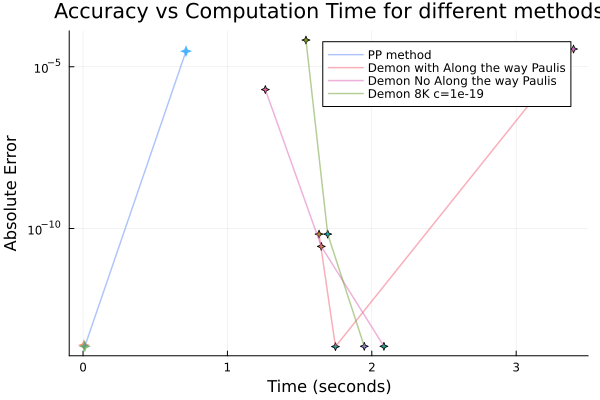

In [5]:
# Calculate accuracy (absolute error)
PPaccuracies = [abs(x) for x in (exactResults .- PPmethodResults)]
Demonaccuracies = [abs(x) for x in (exactResults .- demonResults)]
Demonaccuracies2 = [abs(x) for x in (exactResults .- demonResults2)]
Demonaccuracies3 = [abs(x) for x in (exactResults .- demonResults3)]
println(Demonaccuracies)
println(Demonaccuracies2)
println(Demonaccuracies3)
println(PPaccuracies)
println("Timings:")
println(demonTimings)
println(demonTimings2)
println(demonTimings3)
println(PPtimings)
# Create scatter plot: Accuracy vs Time
# Color by generator index
shapes = [:star4, :rect, :circle, :utriangle, :dtriangle, :hexagon, :star4, :rect, :circle, :utriangle, :dtriangle, :hexagon,]

p = scatter(vec(PPtimings), vec(PPaccuracies), 
    group=repeat(1:length(cp_grid), inner=length(generators)), 
    marker=repeat(shapes[1:length(generators)], outer=length(cp_grid)), 
    xlabel="Time (seconds)", 
    ylabel="Absolute Error", 
    yscale=:log10, 
    title="Accuracy vs Computation Time for different methods", 
    markersize=6, 
    markerstrokewidth=0, 
    alpha=0.7,
    label=false,
    legend=:best)

scatter!(vec(demonTimings), vec(Demonaccuracies),
        group=repeat(1:length(scythe_grid), inner=length(generators)),
        marker=repeat(shapes[1:length(generators)], outer=length(cp_grid)),label=false)

scatter!(p, vec(demonTimings2), vec(Demonaccuracies2),
    group=repeat(1:length(scythe_grid), inner=length(generators)),
    marker=repeat(shapes[1:length(generators)], outer=length(cp_grid)),label=false)

scatter!(p, vec(demonTimings3), vec(Demonaccuracies3),
    group=repeat(1:length(scythe_grid), inner=length(generators)),
    marker=repeat(shapes[1:length(generators)], outer=length(cp_grid)),label=false)
        
# Connect points for each generator (same marker shape)
for i in 1:length(generators)
    idx = i:length(generators):length(vec(PPtimings))
    sorted_idx = idx[sortperm(vec(PPtimings)[idx])]
    plot!(p, vec(PPtimings)[sorted_idx], vec(PPaccuracies)[sorted_idx],linewidth=1.5, alpha=0.5, label="PP method")
end

# Connect points for each generator (same marker shape)
for i in 1:length(generators)
    print(i)
    idx = i:length(generators):length(vec(demonTimings))
    sorted_idx = idx[sortperm(vec(demonTimings)[idx])]
    plot!(p, vec(demonTimings)[sorted_idx], vec(Demonaccuracies)[sorted_idx], linewidth=1.5, alpha=0.5, label="Demon with Along the way Paulis")
end

# Connect points for each generator (same marker shape)
for i in 1:length(generators)
    idx = i:length(generators):length(vec(demonTimings2))
    sorted_idx = idx[sortperm(vec(demonTimings2)[idx])]
    plot!(p, vec(demonTimings2)[sorted_idx], vec(Demonaccuracies2)[sorted_idx], linewidth=1.5, alpha=0.5,  label="Demon No Along the way Paulis")
end

# Connect points for each generator (same marker shape)
for i in 1:length(generators)
    idx = i:length(generators):length(vec(demonTimings3))
    sorted_idx = idx[sortperm(vec(demonTimings3)[idx])]
    plot!(p, vec(demonTimings3)[sorted_idx], vec(Demonaccuracies3)[sorted_idx], linewidth=1.5, alpha=0.5,  label="Demon 8K c=1e-19")
end

display(p)


Currently our methods are lagging behind the standard PP propagation